# Lakes

Multiple ERA5 static climate fields, for example lake cover or vegetation, were recently updated from V15 to V20. For a full comparison of how these fields have changed see `A1.V20_vs_V15.ipynb`.

Moreover, there is also additional information such as how lake cover varies month-to-month and the salinity of lakes.

Given this updated information, it is of interest to establish whether a model trained using this new information can make more accurate predictions than a model without. If so, this indicates that the updated fields are an improvement, i.e. they more closely approximate the real world.

We consider the following predictive models:

* V15: Time varying ERA5 fields + the static V15 climate fields
* V20: Time varying ERA5 fields, the static V15 climate fields + V20 corrections to each of those fields


We take 2016 as a training set, 2017 as a validation set and 2019 as a test set.


---


## 0. Global variables

First we will declare some variables, functions and useful calculations that will be shared among the sections below. If you just want to see the analysis, skip to `1.V15 vs V20`.

In [115]:
#VARIABLES

V15_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016_augmented/'
V20_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented/'


#If the change in a variable is greater than tolerance (e.g. abs(cl) > tolerance), the change is marked as `significant`. 
#The "is significant"/"is not significant" boolean is then used is to define a grouping bitstring category.
#For lake depth dl, tolerance specifies the fracional change e.g. is the change in dl > 10%? 
tolerance = 0.1 


In [116]:
# FUNCTIONS
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns

def calculate_delta_field(filename,parameter):
    
    
    """
    Function to determine the change in a parameter when going from V15 to V20
    """
    
    root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
    version = ['v015', 'v020']
    
    ds = [] #Array to hold results
    for v in version:
        path = root+f'climate.{v}/climate.{v}/639l_2/{filename}'
        ds_i= xr.open_dataset(path,engine='cfgrib',backend_kwargs={'indexpath': ''},filter_by_keys={'shortName':parameter}) #only want this one parameter
        
        ds.append(ds_i)
        
    #Take the difference, and make it a nice pandas df    
    delta_field = ds[1] - ds[0] #V20 - V15
    delta_field =  delta_field.assign_coords({"longitude": (((delta_field.longitude + 180) % 360) - 180)}) #long3 ---> long1
    delta_field = delta_field.to_dataframe().reset_index()
    
    V20_df = ds[1].to_dataframe().reset_index()
    V15_df = ds[0].to_dataframe().reset_index()

    if parameter == '10si': #seaice shortname is inverse to variable name
        parameter='si10'
    
    delta_field[f'V15_{parameter}'] = V15_df[parameter]
    delta_field[f'V20_{parameter}'] = V20_df[parameter]
    delta_field = delta_field.rename(columns={f'{parameter}': f'change_in_{parameter}'})
    delta_field[f'percentage_change_in_{parameter}'] = (delta_field[f'V20_{parameter}'] - delta_field[f'V15_{parameter}']) / delta_field[f'V15_{parameter}']

    return delta_field


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits,markersize,savefig):
    
    """Hacky function plotting the value of `z` at latitude/longitude points
       as a scatter map"""

    try:
        x = ds.longitude
        y = ds.latitude
    except: # different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title,fontsize=30)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])
        
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)

    plt.show()
    
    
    
    
    
def load_predictions(model):

    """For this model, load the predictions and determine the prediction error"""
    
    df = pd.read_parquet(model+'predictions.parquet')
    
    #Calculate some extra columns
    df['predicion_bias'] = df.MODIS_LST - df.predictions
    df['predicion_error'] = abs(df.MODIS_LST - df.predictions)


    print("Mean/Median/Std prediction bias:", df['predicion_bias'].mean(), df['predicion_bias'].median(),df['predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['predicion_error'].mean(), df['predicion_error'].median(),df['predicion_error'].std())

    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 


    return df,df_grouped



def plot_distribution(df,x,xlabel):
    

    """Plot the distribution of the quantity `x` in df """

    #Setup plot env
    h,w = 20,20
    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[x], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0')

    # Config
    ax1.set_xlabel(xlabel)

    ax1.axvline(0,c='0.5', linestyle='--')
    
    #Prints
    print ('Number of samples:', len(df))
    print ('Distribution Mean/Median:', df[x].mean(), df[x].median())

    plt.show()
    
    
    
    
    
    
    
#-------------------------------------
    
def classify(x,tol):
    
    if abs(x) > tol:
        return True
    else:
        return False
    
def classify_dl(x,tol):
    
    if abs(x) > tol:
        return True
    else:
        return False
    
    
        
def bit(x):
    
    if x:
        return 1
    else:
        return 0


def bitstring(list_of_columns):
    
    bitstring=''
    for i in list_of_columns:
        idx = bit(i)
        bitstring += str(idx)
        
    return bitstring
    
#-------------------------------------
    
def significance_test(v1,v2):
    try:
        return ttest_ind(v1, v2)
    except:
        return np.nan

def significance_boolean(x):
    
    try:
        pval = x[-1]
    except:
        #Nans are not subscriptable
        return 'Insignificant'
    
    if (pval > 0.01) or np.isnan(pval): 
        return 'Insignificant'
    else:
        return 'Significant'

    

In [117]:
#CALCULATIONS

#Calculate all the delta fields i.e. the change in parameter V15-->V20
clake_delta_field  = calculate_delta_field('clake','cl')        #How does cl change?
seaice_delta_field = calculate_delta_field('cicecap','10si')    #How does seaice change
cvh_delta_field    = calculate_delta_field('cvh','cvh')         #How does cvh change?
cvl_delta_field    = calculate_delta_field('cvl','cvl')         #How does cvl change
lsm_delta_field    = calculate_delta_field('lsmoro','lsm')      #How does lsm change?
dl_delta_field     = calculate_delta_field('lakedl','dl')      #How does lake depth change?

#Bring all the delta fields together
change_in_fields = pd.concat([clake_delta_field,seaice_delta_field,cvh_delta_field,cvl_delta_field,lsm_delta_field,dl_delta_field],axis=1)
change_in_fields = change_in_fields.loc[:,~change_in_fields.columns.duplicated()] #remove duplicated column names that arise due to the concat


# Classify every grid point according to the delta fields
# First create extra boolean columns for whether the change in the field is significant, where significane is determined by `tolerance`     
for parameter in ['cl','si10','cvh','cvl','lsm']:
    change_in_fields[f'{parameter}_change_is_significant'] = change_in_fields.apply(lambda x : classify(x[f'change_in_{parameter}'],tolerance), axis = 1)
    
#handle dl separatley since this is not a fractional 0-1 features
change_in_fields[f'dl_change_is_significant'] = change_in_fields.apply(lambda x : classify_dl(x[f'change_in_dl']/x[f'V15_dl'],tolerance), axis = 1)
    

    
# Then create a single group bitstring for all combinations of booleans
change_in_fields[f'bitstring'] = change_in_fields.apply(lambda x : bitstring( [x['cl_change_is_significant'],
                                                                               x['cvh_change_is_significant'],
                                                                               x['cvl_change_is_significant'],
                                                                               x['dl_change_is_significant'],
                                                                               x['lsm_change_is_significant'],
                                                                               x['si10_change_is_significant']    # ALPHABETICAL
                                                                              ]
                                                                               ), axis = 1)

In [118]:
display_table = change_in_fields.groupby(['bitstring']).count()[['values']]
display_table = display_table.rename(columns={"values": "Number of Pixels"})
display(display_table.sort_values(by='Number of Pixels',ascending=False))

Number of Pixels
bitstring                  
000000               362608
000100               170901
000101                 2661
100100                 2488
100110                 1715
000110                  489
000111                  359
100000                  240
100010                  119
000001                  101
100101                   86
001100                   64
000010                   44
100111                   37
001110                   37
101110                   29
000011                   22
011100                   18
101100                   13
010100                   13
001000                   11
001101                    6
100011                    5
011000                    3
001111                    2
101010                    2
001010                    2
111110                    2
100001                    1
011110                    1
010000                    1

---


## 1. V15 vs V20 <a name="V15V20"></a>

In [119]:
V15_predictions,V15_predictions_averaged = load_predictions(V15_model)
V20_predictions,V20_predictions_averaged = load_predictions(V20_model)

Mean/Median/Std prediction bias: -0.041747708 0.10055542 4.081224
Mean/Median/Std prediction error: 3.0393808 2.3208313 2.7240207
Mean/Median/Std prediction bias: 0.13015294 0.26712036 4.0542684
Mean/Median/Std prediction error: 3.0233936 2.3095398 2.7042806


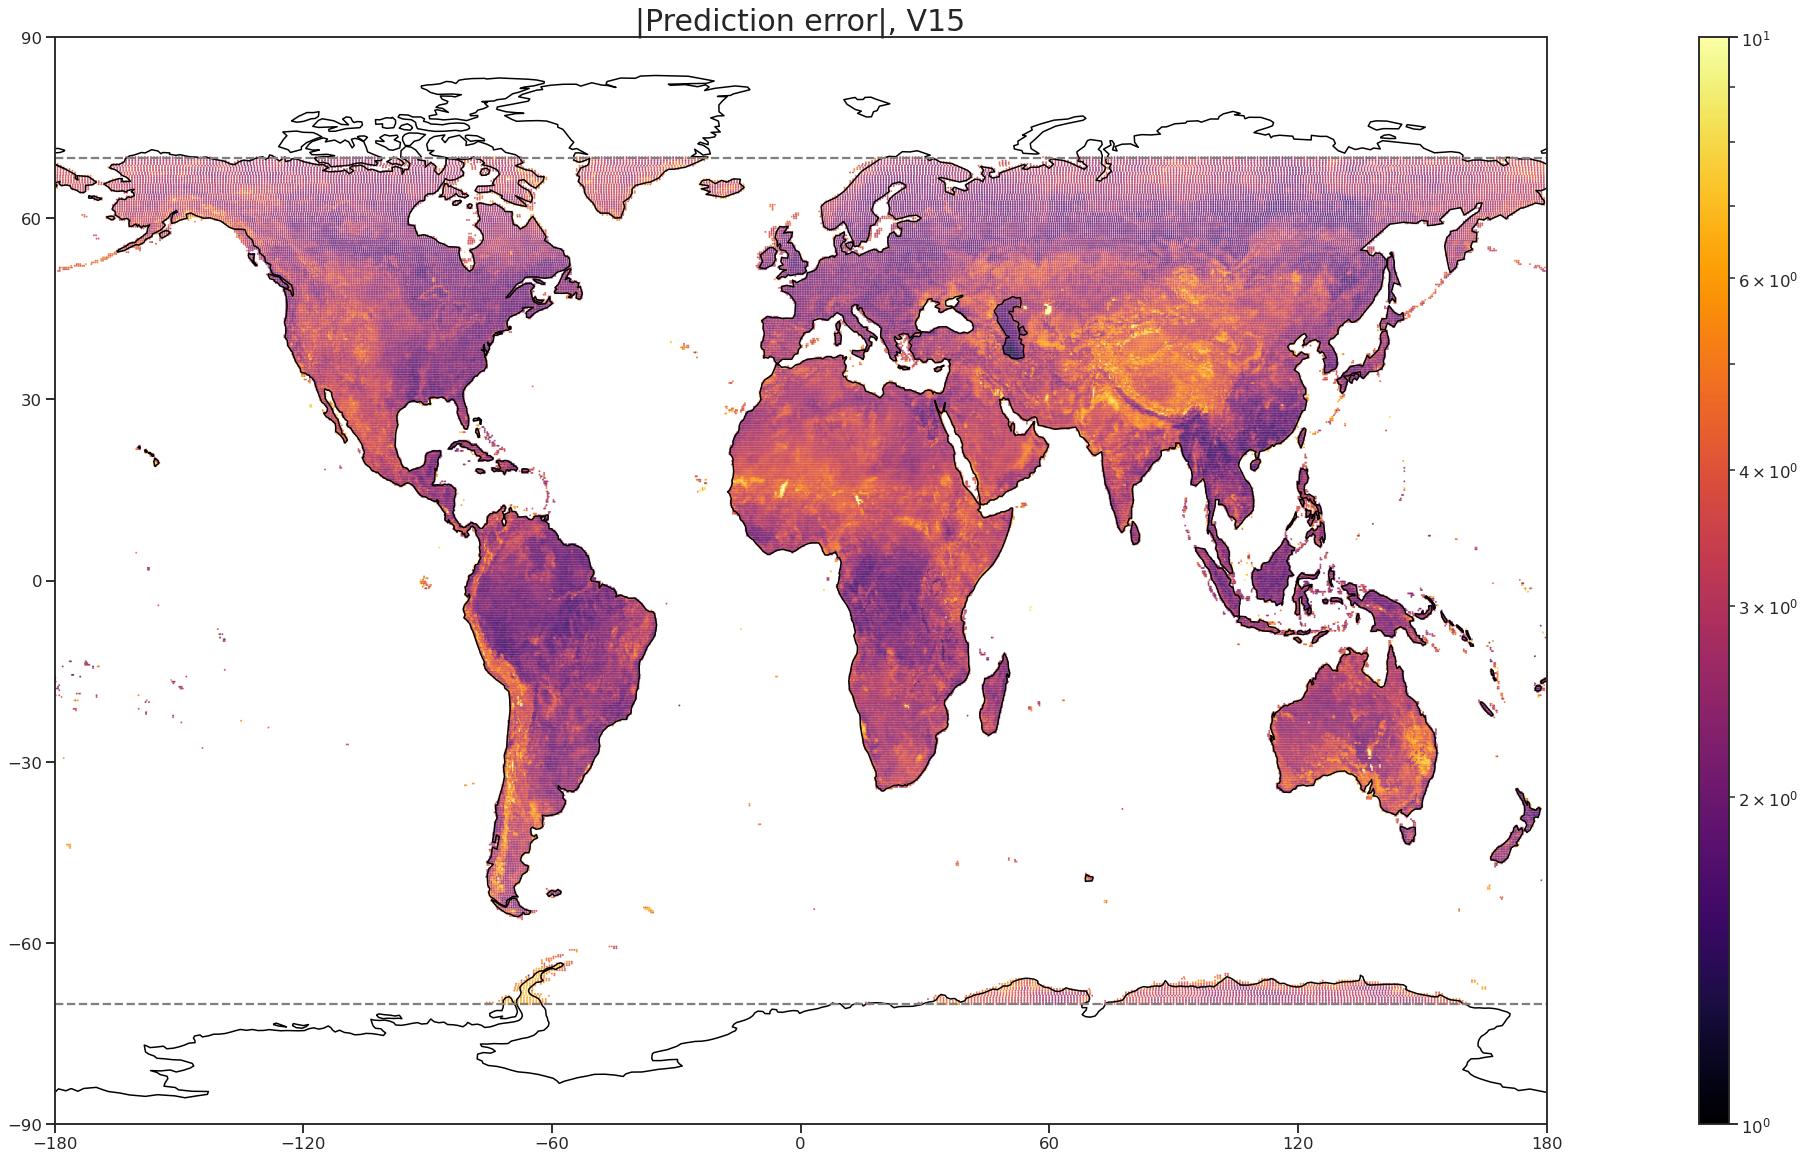

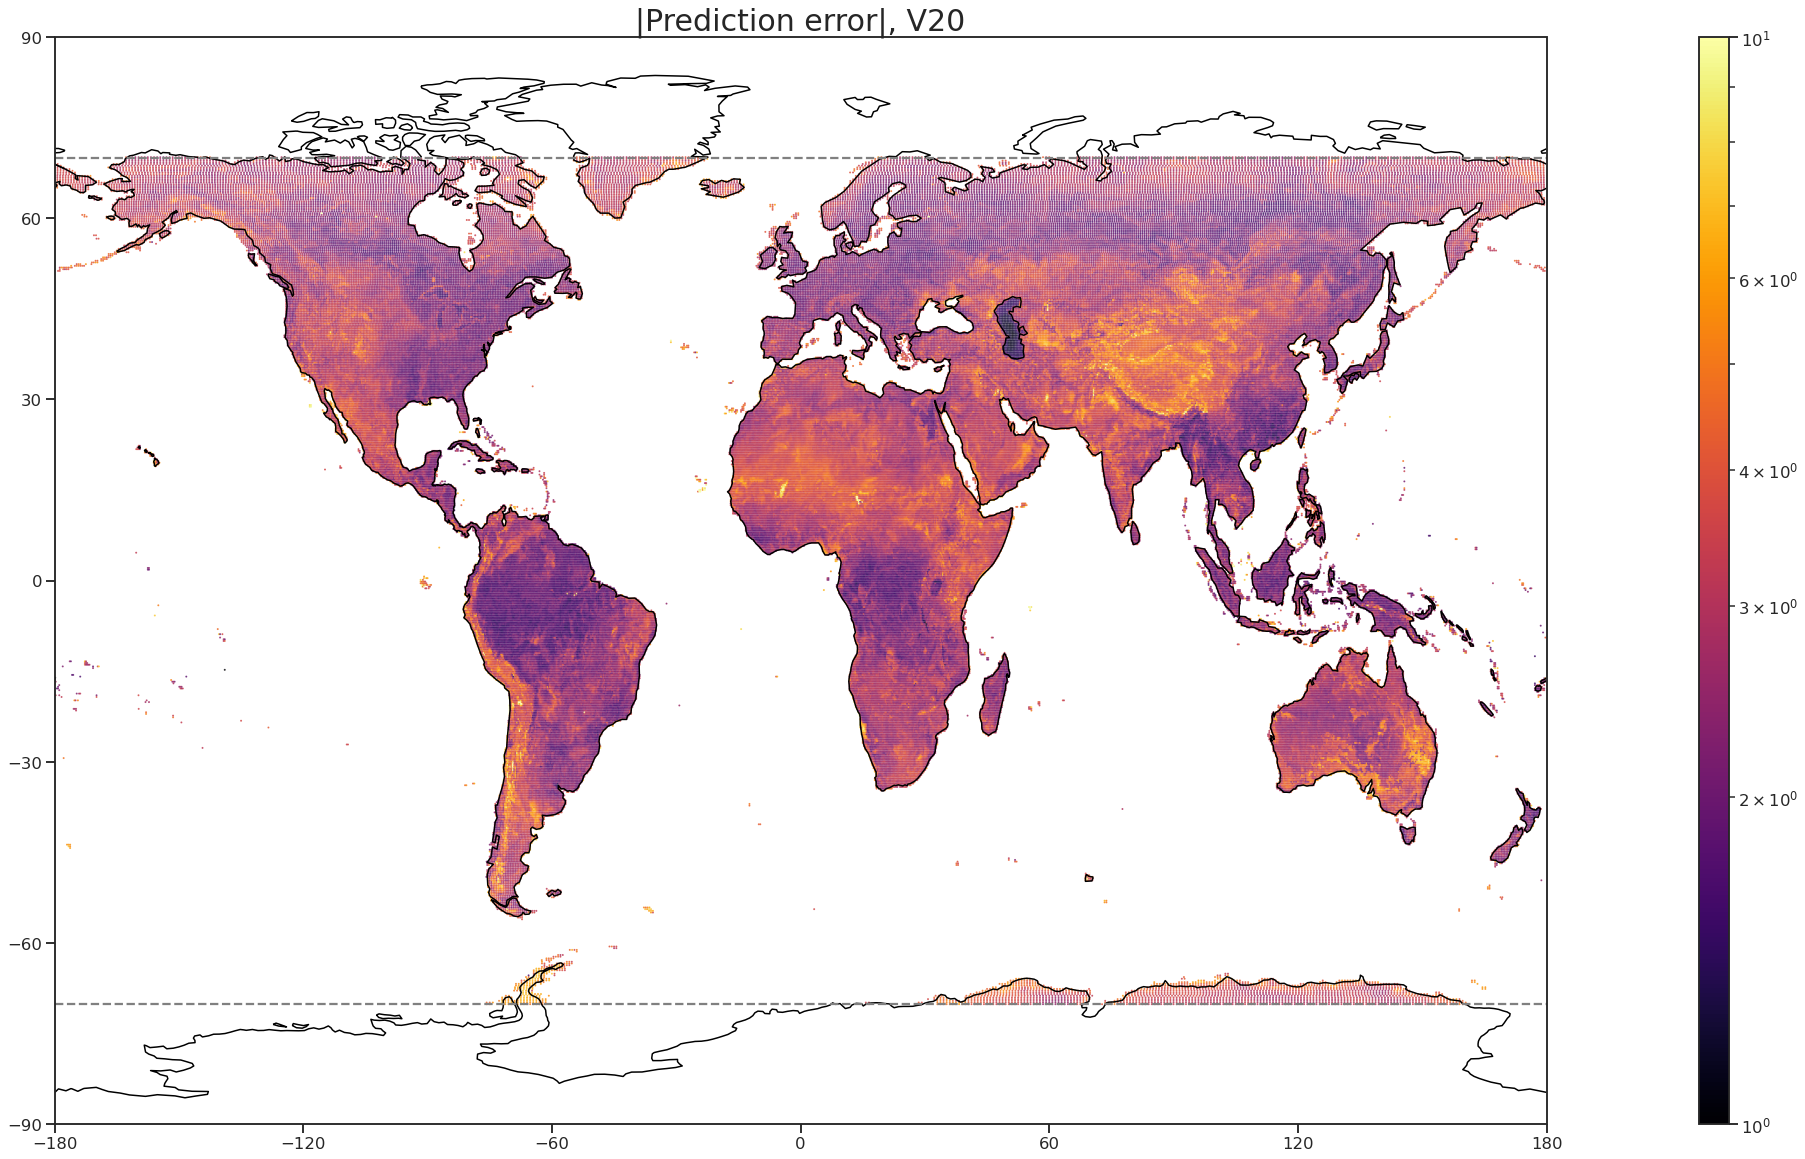

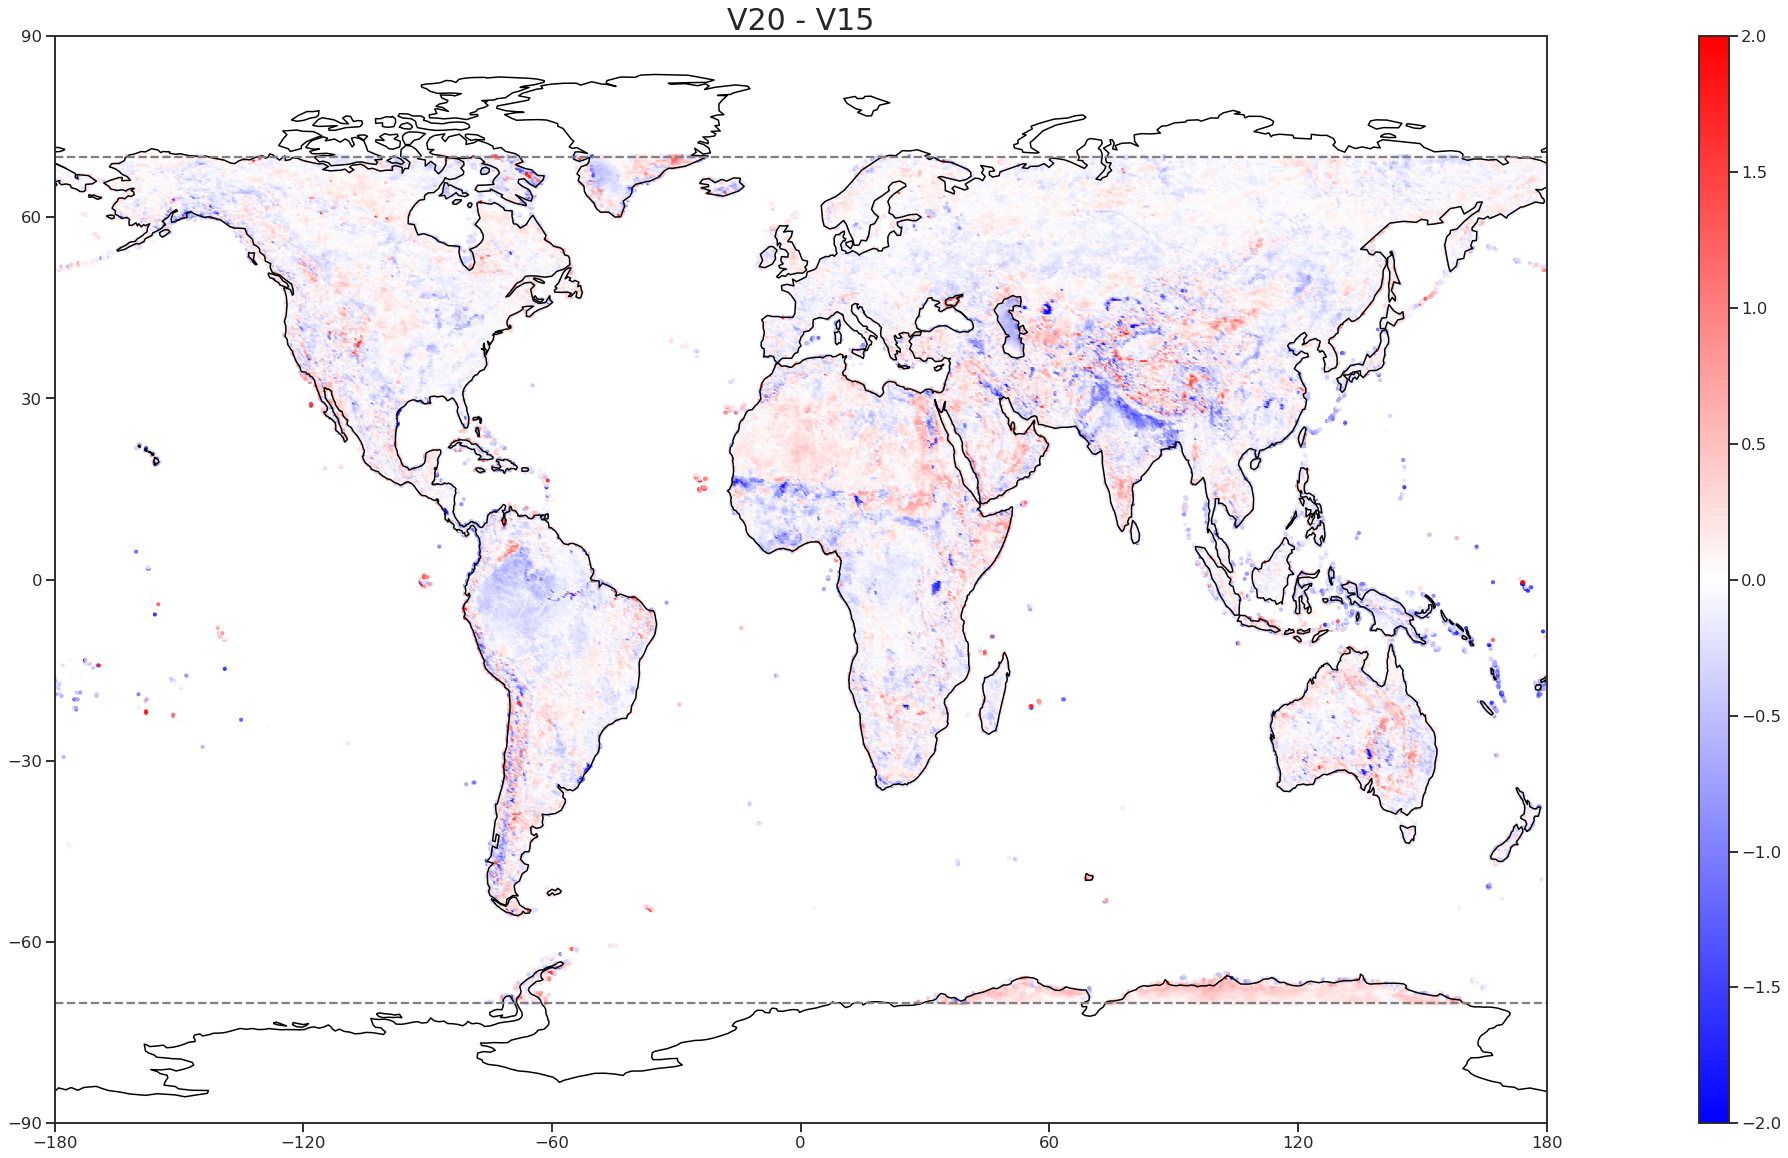

In [120]:
#Plot the map of the prediction error  
cmap = plt.cm.inferno
logscale = True #None
vmin = 1
vmax = 10
plot_map(V15_predictions_averaged,'predicion_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V15',limits=None,markersize=1,savefig=None)
plot_map(V20_predictions_averaged,'predicion_error',vmin=vmin,vmax=vmax,cmap=cmap,logscale=logscale,title='|Prediction error|, V20',limits=None,markersize=1,savefig=None)

    
#Create a new df that will just hold the differences, and plot it    
data = {'latitude_ERA':   V20_predictions_averaged.latitude_ERA, 
        'longitude_ERA':  V20_predictions_averaged.longitude_ERA,
        'MODIS_LST':      V20_predictions_averaged.MODIS_LST,
        'V15_prediction': V15_predictions_averaged.predictions,
        'V20_prediction': V20_predictions_averaged.predictions,
        'V15_error':      V15_predictions_averaged.predicion_error,
        'V20_error':      V20_predictions_averaged.predicion_error,
        'delta':          V20_predictions_averaged.predicion_error - V15_predictions_averaged.predicion_error}
V20_V15 = pd.DataFrame(data)    
plot_map(V20_V15,'delta',vmin=-2,vmax=+2,cmap=plt.cm.bwr,logscale=False,title='V20 - V15',limits=None,markersize=10,savefig=None)

### 1A. Apply "change in lake cover" mask
Apply a mask to look only at those points where `cl` changed appreciably

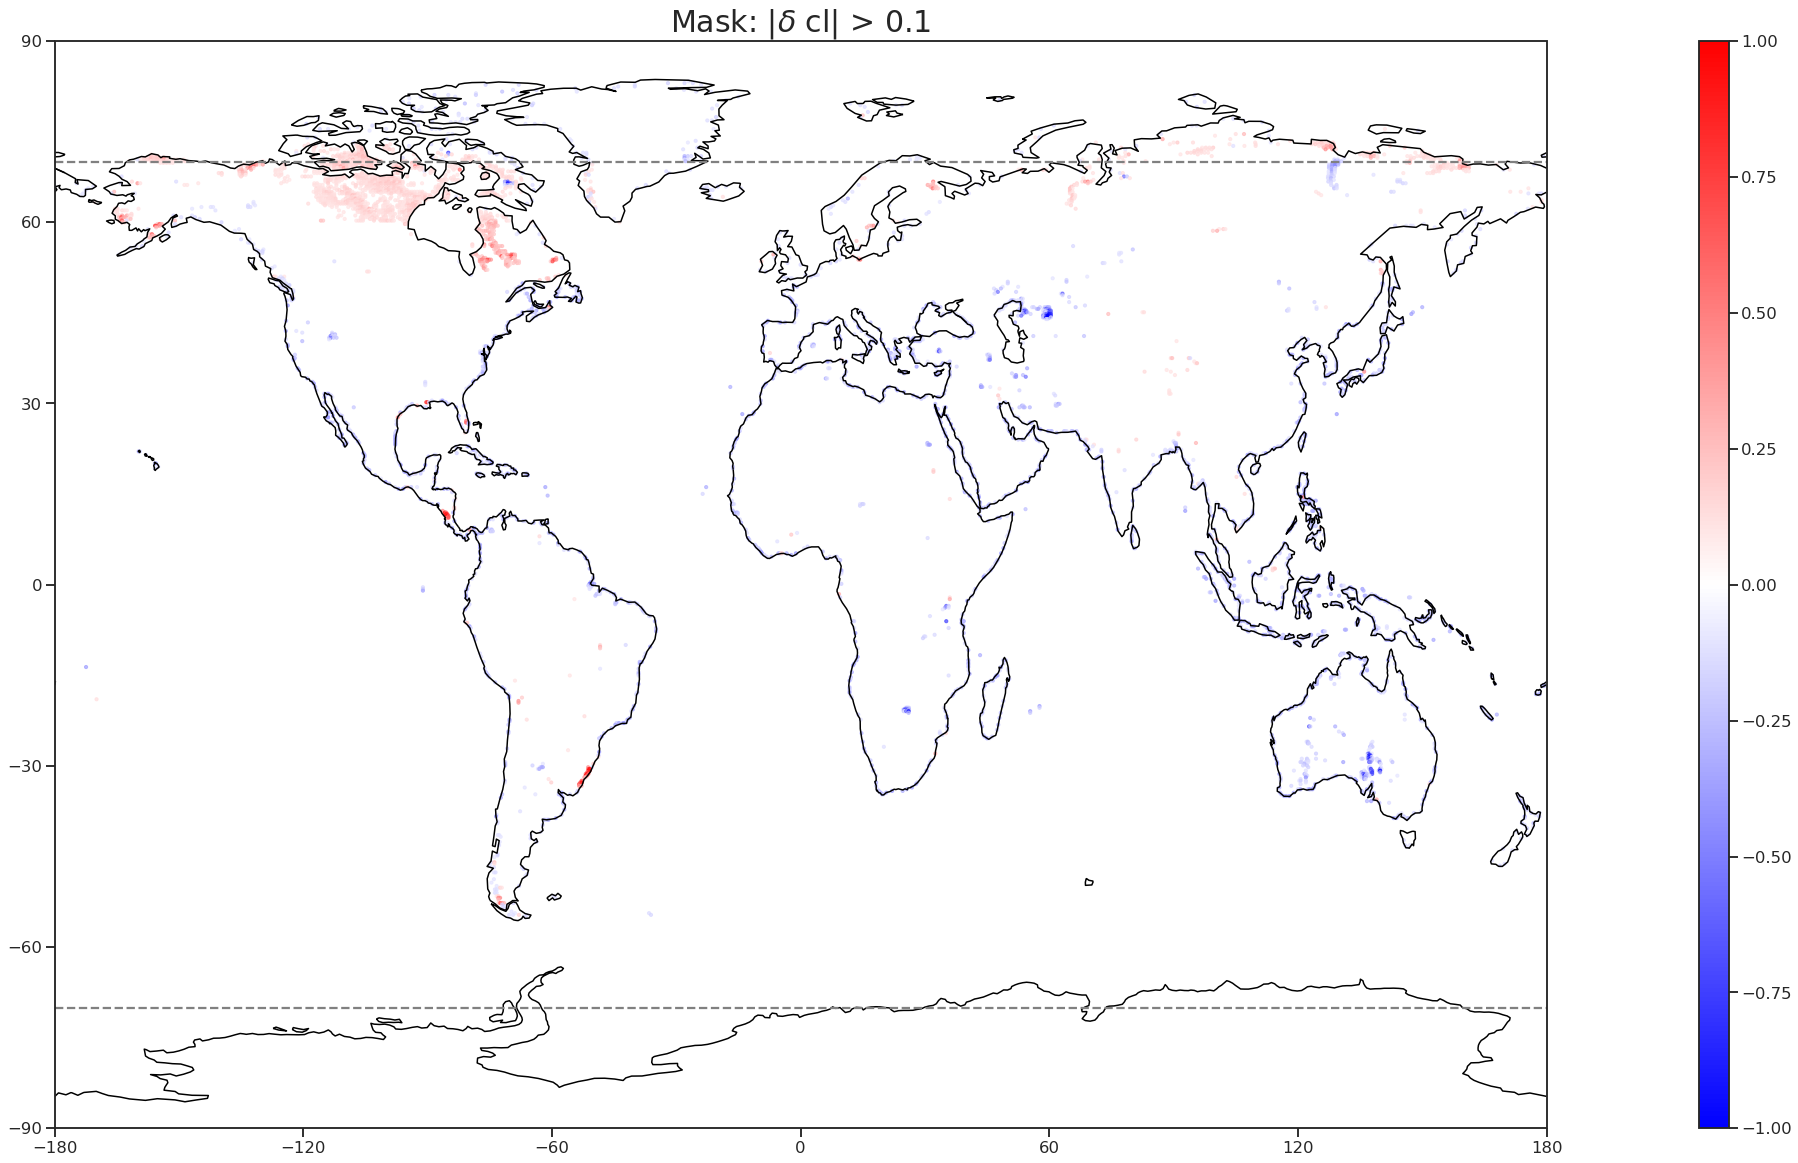

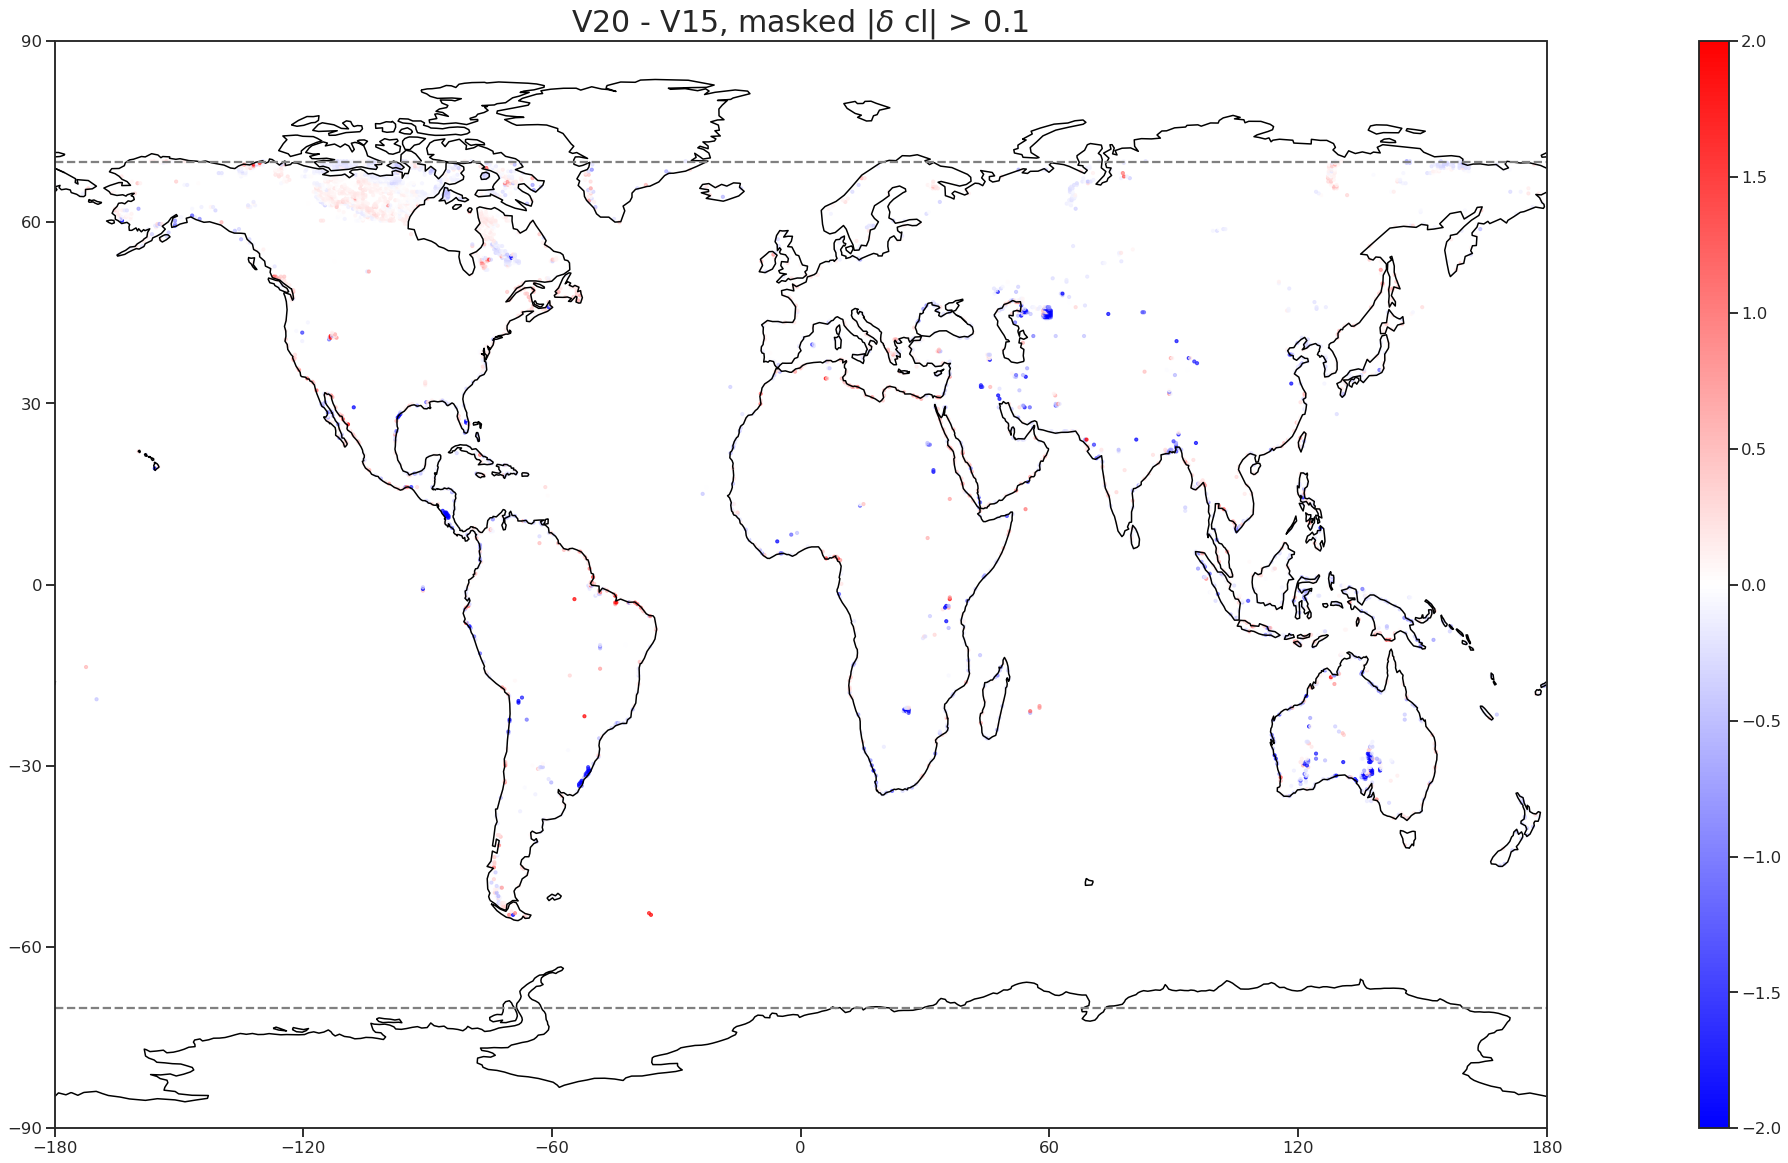

Number of samples: 4314
Distribution Mean/Median: -0.15390289 -0.013284564


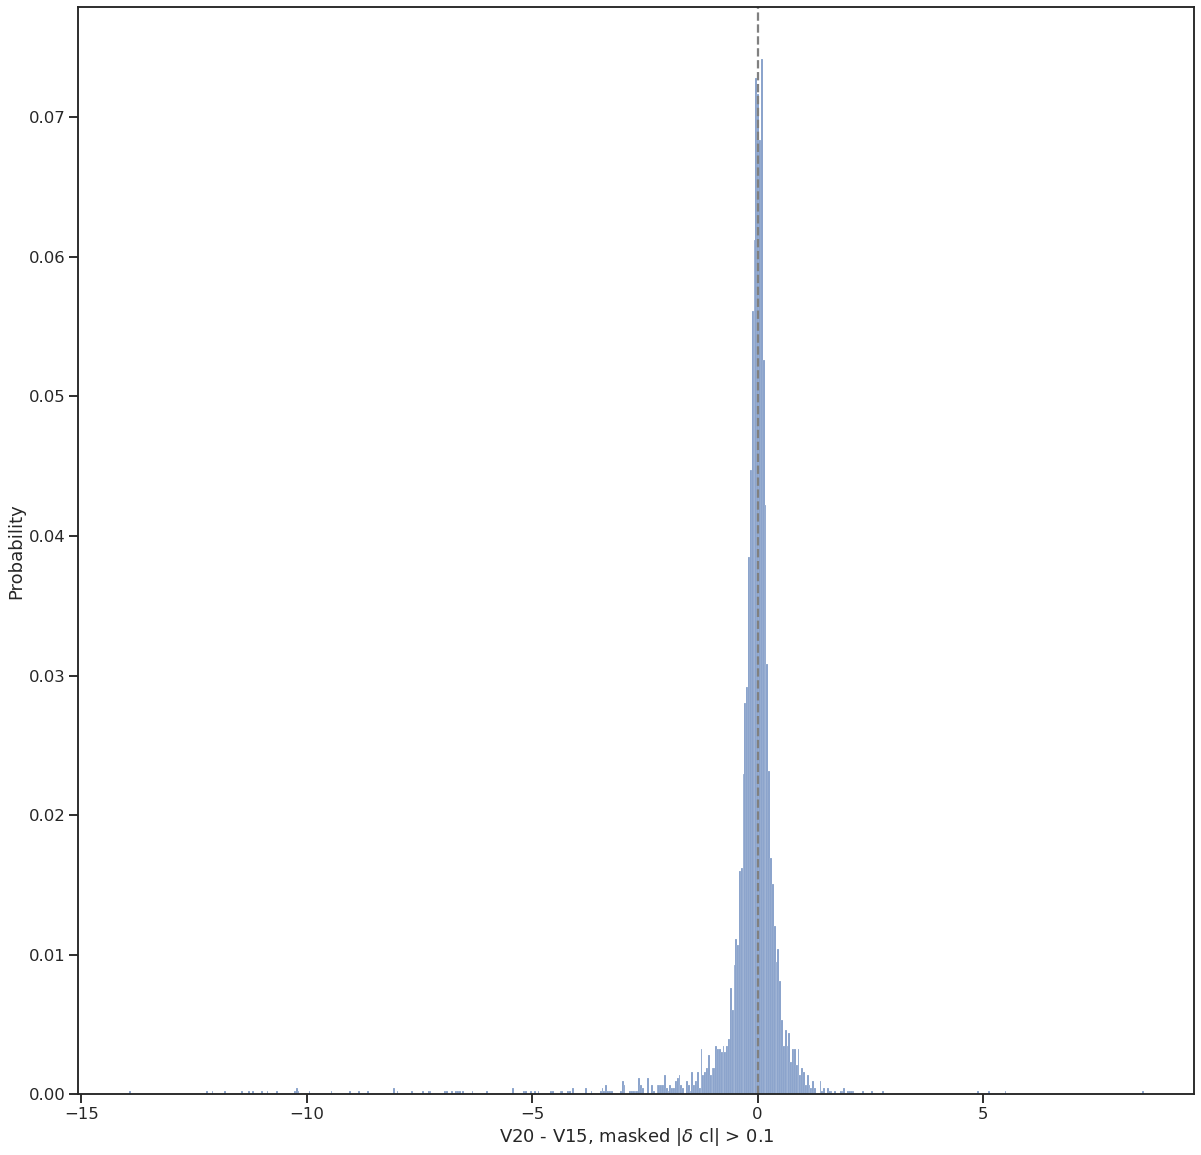

Masked points:


latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
440     -21.779853     -52.148148  303.927155      305.344116      314.944519   
914      -2.388758     -54.562500  301.231934      304.019257      309.612976   
1750     24.028095      69.000000  313.732483      309.048828      303.119598   
2315     41.170945    -113.400000  294.736176      294.245392      302.931915   
780      -6.323183     -80.718750  311.564301      308.391449      304.894409   
...            ...            ...         ...             ...             ...   
2407     44.262278      59.625000  304.117401      289.167725      302.738159   
345     -28.243550     137.500000  315.578735      299.290649      312.212677   
338     -28.524581     137.187500  312.487457      295.952759      311.568665   
339     -28.524581     137.500000  314.010529      297.675995      311.415009   
344     -28.243550     137.187500  313.954041      295.947571      312.128082   

      V15_error  V20_error      delta  values   step  ...     V15_dl  \
440    2.478057  11.043860   8.565804  370444 0 days  ...   8.000000   
914    2.864736   8.381800   5.517063  282366 0 days  ...   3.000000   
1750   5.621420  10.745070   5.123649  162045 0 days  ...   2.580078   
2315   3.573472   8.450400   4.876928   94518 0 days  ...   3.000000   
780    4.953901   7.726332   2.772430  300193 0 days  ...  12.924805   
...         ...        ...        ...     ...    ...  ...        ...   
2407  15.206730   3.779034 -11.427696   83288 0 days  ...   7.302734   
345   16.288105   4.484949 -11.803156  397457 0 days  ...   4.690430   
338   16.549955   4.445524 -12.104431  398608 0 days  ...   4.690430   
339   16.346096   4.150989 -12.195107  398609 0 days  ...   4.690430   
344   18.006447   4.067714 -13.938733  397456 0 days  ...   4.690430   

         V20_dl  percentage_change_in_dl  cl_change_is_significant  \
440    9.894531                 0.236816                      True   
914   10.000000                 2.333333                      True   
1750   3.755859                 0.455715                      True   
2315  27.000000                 8.000000                      True   
780   30.428711                 1.354288                      True   
...         ...                      ...                       ...   
2407   1.000000                -0.863065                      True   
345    1.000000                -0.786800                      True   
338    1.000000                -0.786800                      True   
339    1.000000                -0.786800                      True   
344    1.000000                -0.786800                      True   

      si10_change_is_significant  cvh_change_is_significant  \
440                        False                       True   
914                        False                       True   
1750                       False                      False   
2315                       False                      False   
780                        False                      False   
...                          ...                        ...   
2407                       False                      False   
345                        False                      False   
338                        False                      False   
339                        False                      False   
344                        False                      False   

      cvl_change_is_significant  lsm_change_is_significant  \
440                        True                       True   
914                        True                       True   
1750                      False                       True   
2315                      False                       True   
780                       False                       True   
...                         ...                        ...   
2407                      False                       True   
345                       False                       True   
338         

latitude_ERA  longitude_ERA   MODIS_LST  V15_prediction  V20_prediction  \
4229     69.836018    -124.500000  262.706909      264.561462      262.181702   
4065     68.711899     -82.222222  260.665619      261.293121      260.023590   
4150     69.273959     -93.000000  257.163452      257.806274      256.568970   
4086     68.992929    -132.750000  265.609497      266.431580      266.972809   
3410     63.934391     -90.000000  260.438751      260.418793      260.382141   
4133     69.273959    -132.000000  264.736176      265.937744      262.660919   
3276     62.810270     -92.250000  262.579620      261.656342      260.920441   
4006     68.149839      77.760000  265.037994      264.706268      262.853241   

      V15_error  V20_error     delta  values   step  ...  V15_dl     V20_dl  \
4229   3.132460   2.845005 -0.287455   17396 0 days  ...    25.0   8.154297   
4065   2.918608   3.085910  0.167302   19377 0 days  ...    25.0   9.800781   
4150   3.109565   3.438165  0.328600   18398 0 days  ...    25.0  10.000000   
4086   2.536222   2.962801  0.426579   18825 0 days  ...    25.0   7.000000   
3410   2.598608   3.091508  0.492900   28618 0 days  ...    25.0  12.132812   
4133   2.925280   3.610393  0.685113   18346 0 days  ...    25.0   3.808594   
3276   2.549397   3.580859  1.031461   31044 0 days  ...    25.0  28.157227   
4006   2.687000   3.733055  1.046055   20096 0 days  ...    25.0   3.103516   

      percentage_change_in_dl  cl_change_is_significant  \
4229                -0.673828                      True   
4065                -0.607969                      True   
4150                -0.600000                      True   
4086                -0.720000                      True   
3410                -0.514687                      True   
4133                -0.847656                      True   
3276                 0.126289                      True   
4006                -0.875859                      True   

      si10_change_is_significant  cvh_change_is_significant  \
4229                       False                      False   
4065                       False                      False   
4150                       False                      False   
4086                       False                      False   
3410                       False                      False   
4133                       False                      False   
3276                       False                      False   
4006                       False                      False   

      cvl_change_is_significant  lsm_change_is_significant  \
4229                       True                      False   
4065                       True                      False   
4150                       True                      False   
4086                       True                      False   
3410                       True                      False   
4133                       True                      False   
3276                       True                      False   
4006                       True                      False   

      dl_change_is_significant  bitstring  
4229                      True     101100  
4065                      True     101100  
4150                      True     101100  
4086                      True     101100  
3410                      True     101100  
4133                      True     101100  
3276                      True     101100  
4006                      True     101100  

[8 rows x 45 columns]

Classification table:


Number of Pixels  AverageDelta  Percentage  \
bitstring                                               
100000                  234     -0.192490    5.424200   
100010                  104     -0.101209    2.410756   
100011                    3     -0.105439    0.069541   
100100                 2392     -0.053458   55.447381   
100101                   19      0.170830    0.440427   
100110                 1512     -0.336010   35.048679   
100111                   17     -0.189134    0.394066   
101010                    2      0.789066    0.046361   
101100                    8      0.486319    0.185443   
101110                   21      0.394420    0.486787   
111110                    2      7.041433    0.046361   

                           Stats (t-statistic,p-value) Significant Change?  
bitstring                                                                   
100000        (1.996783817109343, 0.04642985343989715)       Insignificant  
100010       (0.8636803270805503, 0.38876800907529985)       Insignificant  
100011       (0.15595870268901635, 0.8836199321021785)       Insignificant  
100100        (2.174490351294765, 0.02971719330884196)       Insignificant  
100101       (-0.5035218371698965, 0.6176647546463794)       Insignificant  
100110     (6.428846519940273, 1.4890045307006747e-10)         Significant  
100111       (0.9960700862735284, 0.32668890848655585)       Insignificant  
101010        (-0.7021267538457692, 0.555311444912789)       Insignificant  
101100      (-3.3043994483637684, 0.00521642231127351)         Significant  
101110      (-1.7522487041987298, 0.08739453609148987)       Insignificant  
111110       (-5.235270338561034, 0.03460297116908341)       Insignificant

-----------------------------------------------------------


In [122]:
#for p in [0.1,0.3,0.5]: #Only get points with change in lake cover > p]
for p in [0.1]:
    #Create a mask
    mask = change_in_fields.query(f'abs(change_in_cl) > {p}')

    #Plot the mask
    plot_map(mask,'change_in_cl',vmin=-1,vmax=1,cmap=plt.cm.bwr,logscale=False,title=f'Mask: |${{\delta}}$ cl| > {p}',limits=None,markersize=10,savefig=None) #What does this mask look like?


    #Apply the mask to the global error_delta_field from earlier
    V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

    # Plot it, along with a distribution of the errors
    plot_map(V20_V15_masked,
             'delta',
             vmin=-2,vmax=+2,
             cmap= plt.cm.bwr,
             logscale=False,
             title=f'V20 - V15, masked |${{\delta}}$ cl| > {p}',
             limits=None,
             markersize=10,
             savefig=None)


    plot_distribution(V20_V15_masked,'delta',f'V20 - V15, masked |${{\delta}}$ cl| > {p}')
    
    print('Masked points:')
    display(V20_V15_masked.sort_values(by=['delta'],ascending=False))
    bit10 = V20_V15_masked.query('bitstring=="101100"')
    display(bit10.sort_values(by=['delta']))    
    #Classification table. For each group/bitstring surface some numbers
    classification_table                                = V20_V15_masked.groupby('bitstring').agg(**{'Number of Pixels':pd.NamedAgg('delta','size'),'AverageDelta':pd.NamedAgg('delta','mean')})     # For each group, count number of pixels and get the average delta      
    classification_table["Percentage"]                  = 100.0* classification_table['Number of Pixels'] / sum(classification_table["Number of Pixels"])                                            # Express number of pixels as a percentage
    classification_table['Stats (t-statistic,p-value)'] = V20_V15_masked.groupby('bitstring').apply(lambda x: significance_test(x['V15_error'], x['V20_error']))                                     # For each group, do a ttest between the V15_errors and the V20_errors
    classification_table['Significant Change?']         = classification_table['Stats (t-statistic,p-value)'].apply(lambda x: significance_boolean(x))
    print('Classification table:')
    display(classification_table)
    print ('-----------------------------------------------------------')
    
    
    
    
    
    
    
    


### 1B. Apply bitstring mask

Alternatively, we can look at how the prediction errors change **for each of the grouping bitstring categories**


In [109]:
list_of_bitstrings = display_table.query('`Number of Pixels` > 100 ').drop(labels='000000', axis=0).sort_values(by=['Number of Pixels'],ascending=False).index.values #All the bitstring groups with a certain number of points, excluding the zero change group
#lake_bitstrings = list_of_bitstrings[[x[0] == '1' for x in list_of_bitstrings.index]].sort_values(by=['Number of Pixels'],ascending=False).index.values #Subselect lake change 
display(list_of_bitstrings)

array(['000100', '000101', '100100', '100110', '000110', '000111',
       '100000', '100010', '000001'], dtype=object)

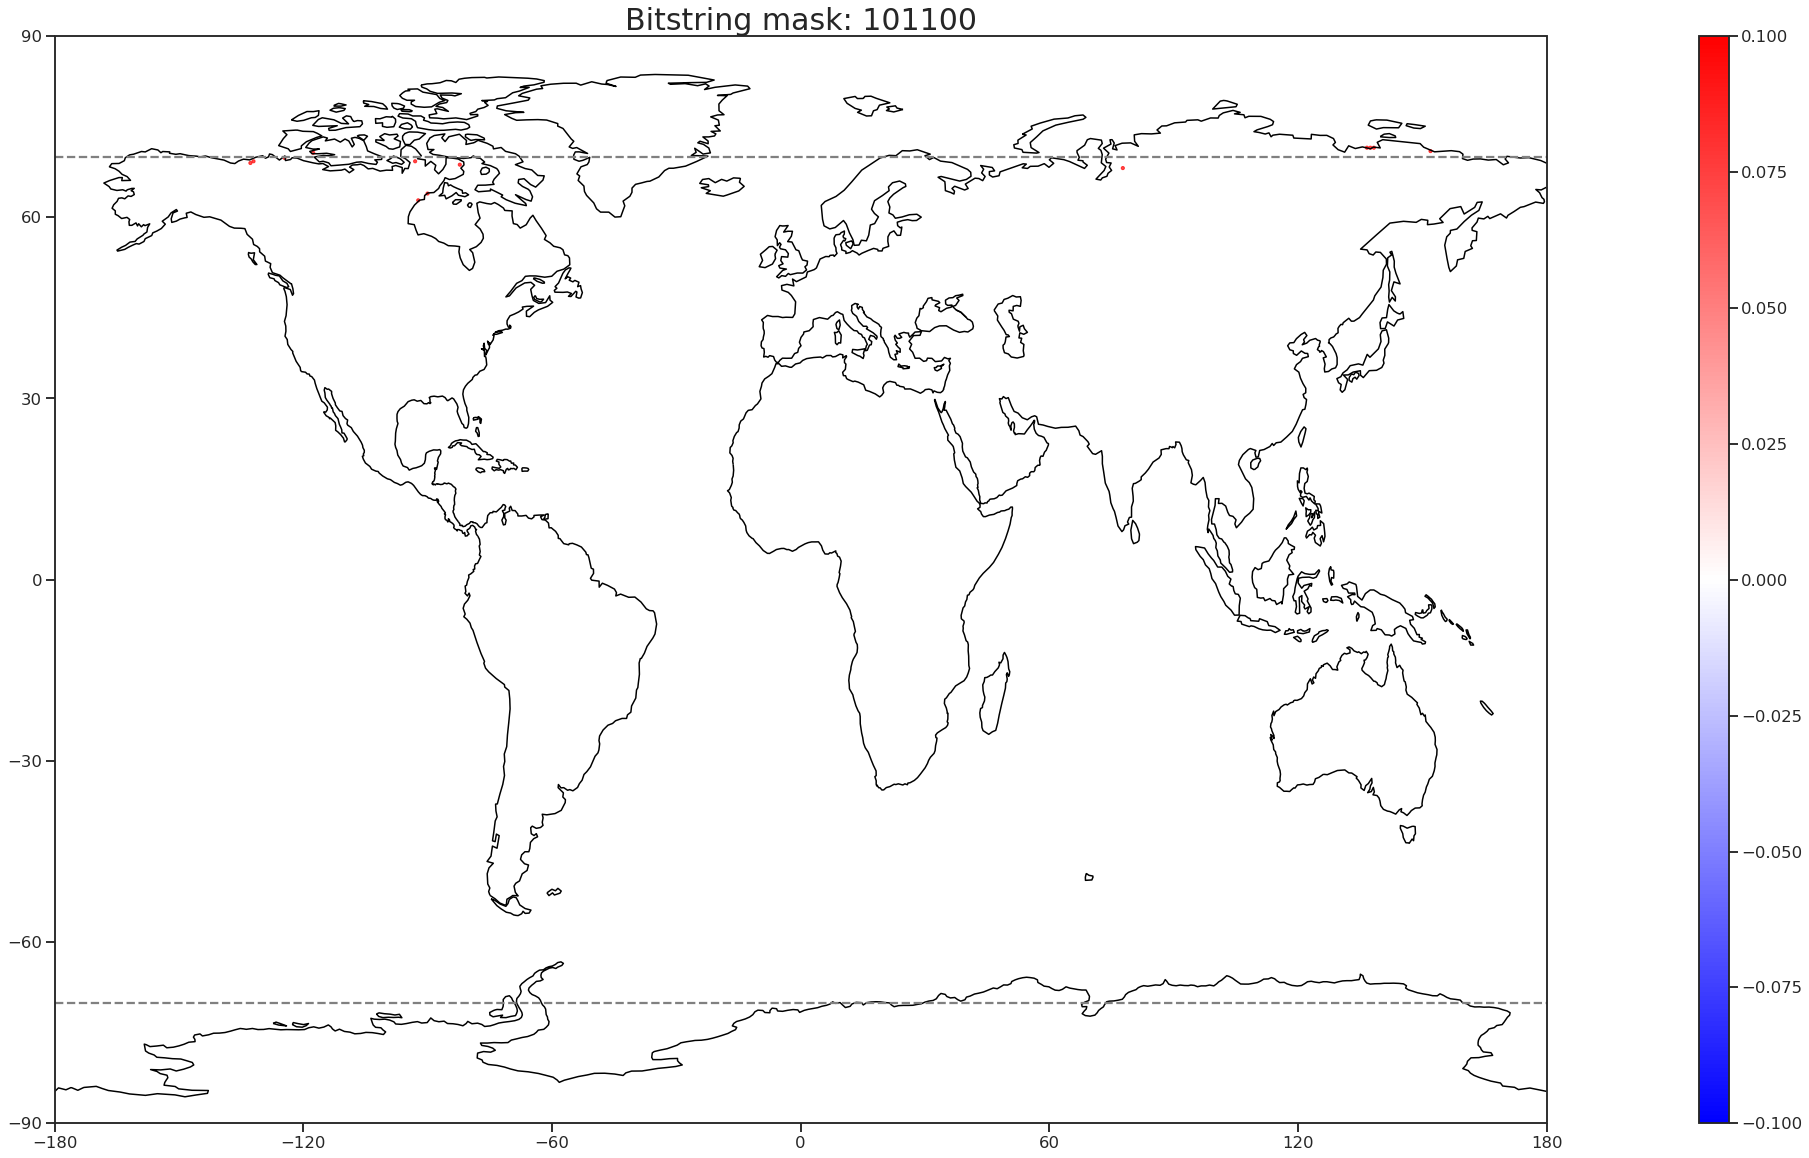

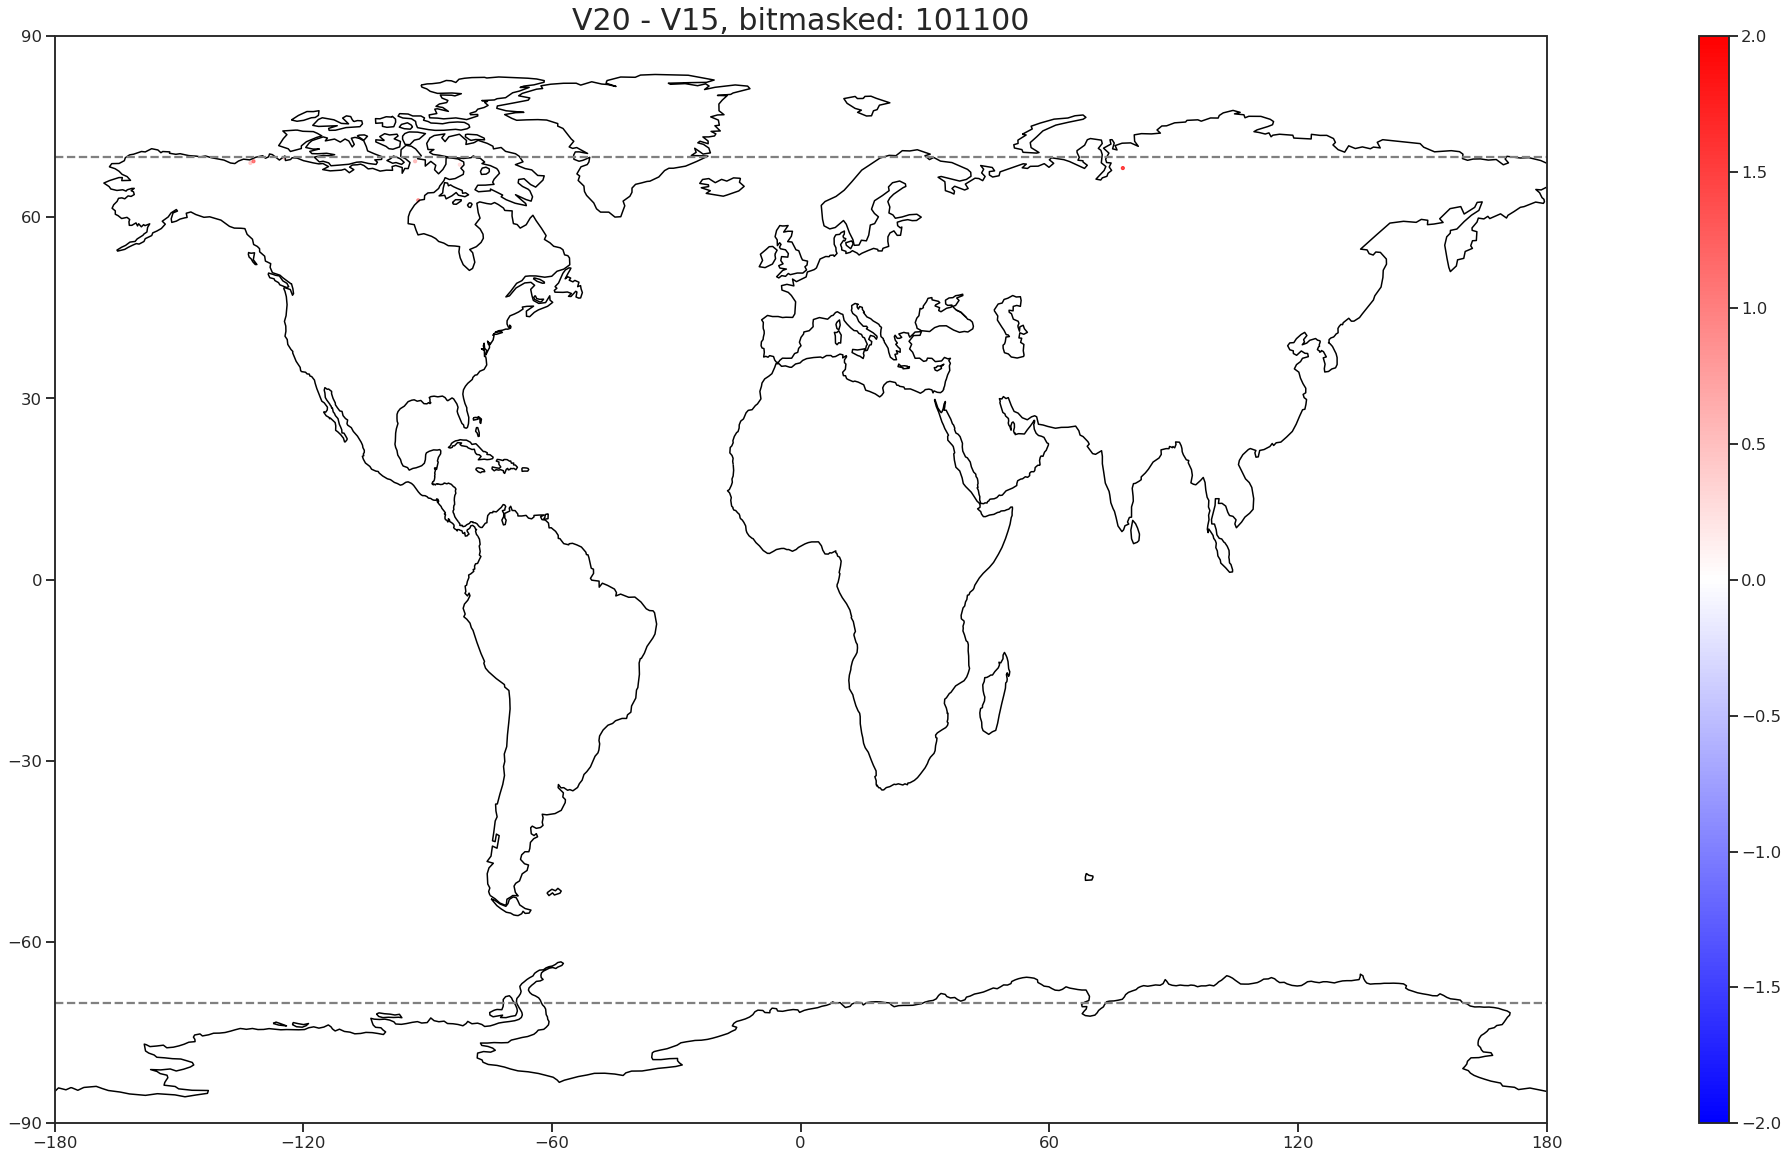

Number of samples: 8
Distribution Mean/Median: 1.0429437 0.61324596


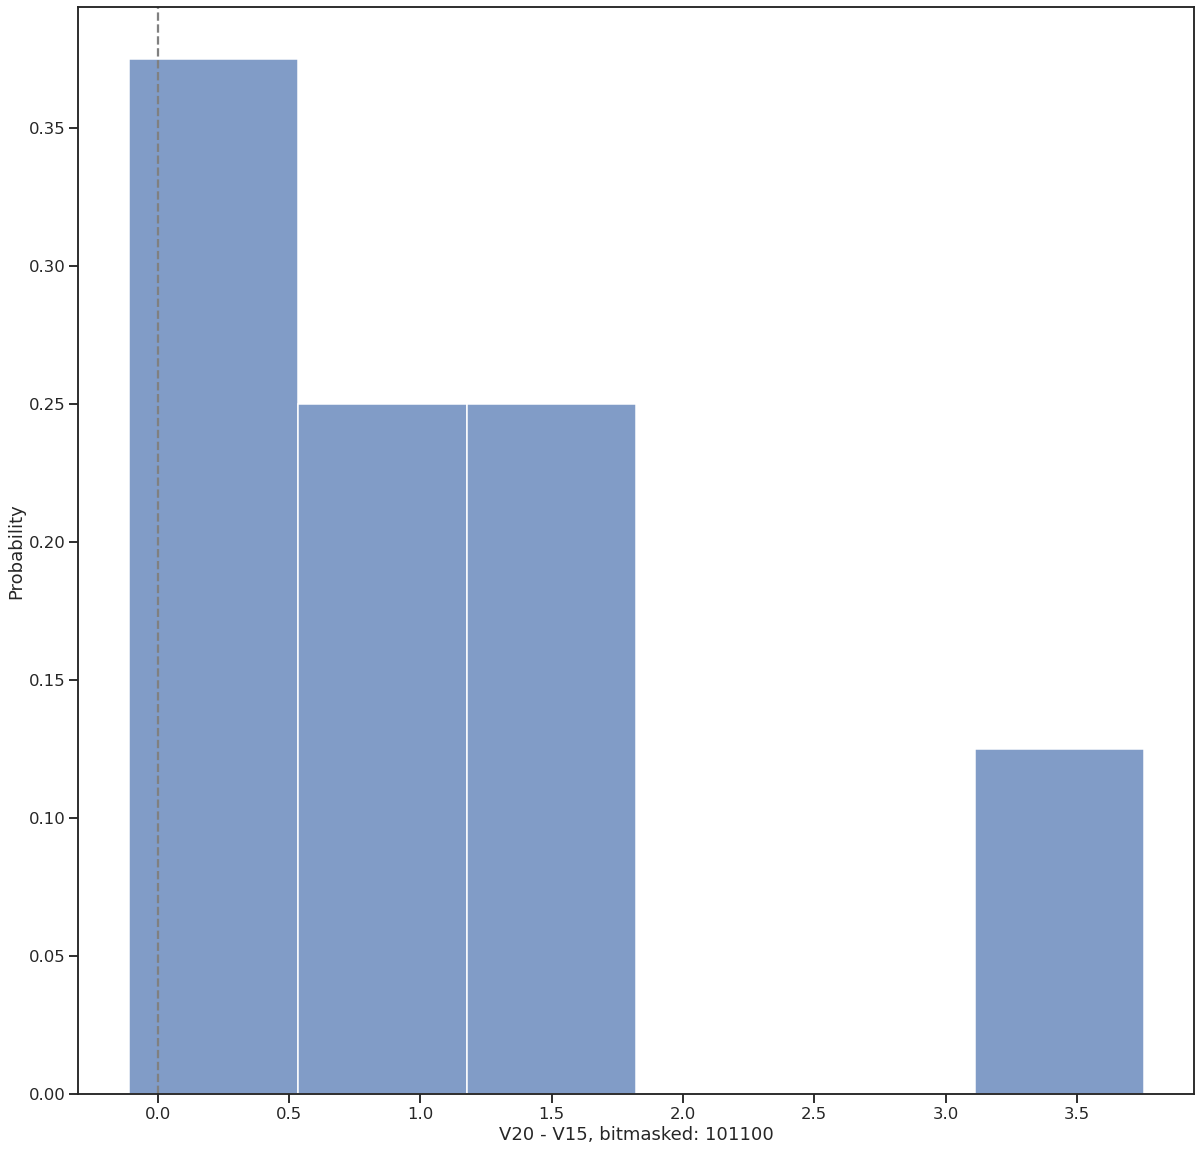

In [111]:
list_of_bitstrings = ['101100']

for p in list_of_bitstrings: 
    #Create a mask
    mask = change_in_fields.query(f'bitstring == "{p}"')
    
    
    #Plot the mask
    plot_map(mask,'change_in_cl',vmin=-0.1,vmax=0.1,cmap=plt.cm.bwr,logscale=False,title=f'Bitstring mask: {p}',limits=None,markersize=10,savefig=None) #What does this mask look like?


    #Apply the mask to the global error_delta_field from earlier
    V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.
    
    if len(V20_V15_masked) == 0:
        print ('No values with this group')
        continue

    # Plot it, along with a distribution of the errors
    plot_map(V20_V15_masked,
             'delta',
             vmin=-2,vmax=2,
             cmap= plt.cm.bwr,
             logscale=False,
             title=f'V20 - V15, bitmasked: {p}',
             limits=None,
             markersize=10,
             savefig=None)


    plot_distribution(V20_V15_masked,'delta',f'V20 - V15, bitmasked: {p}')
    

## 1C. Noise

We have two options for evaluating the noise, one more stringent than the other:


* Look at all the points where nothing changed appreciably, i.e. the all zeros bitstring group
* Look at all the points where nothing changed AT ALL.

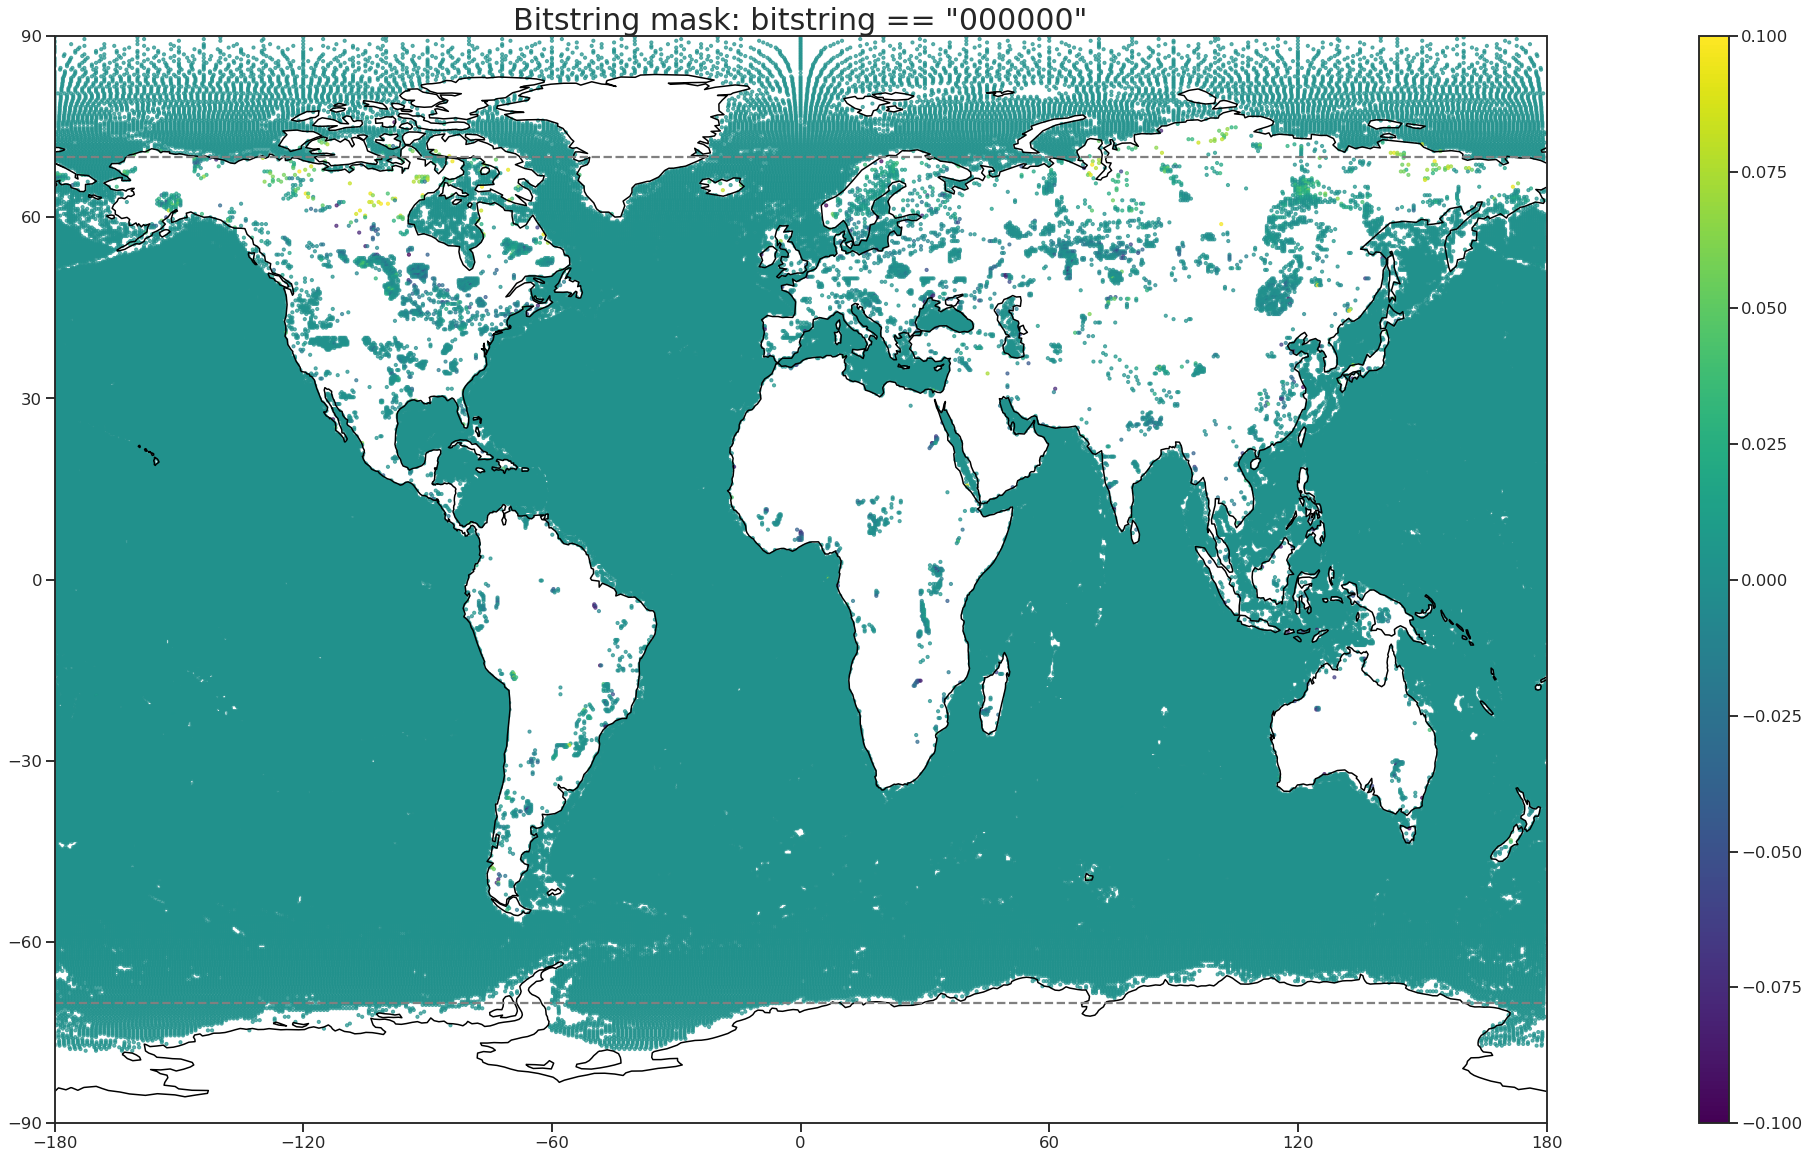

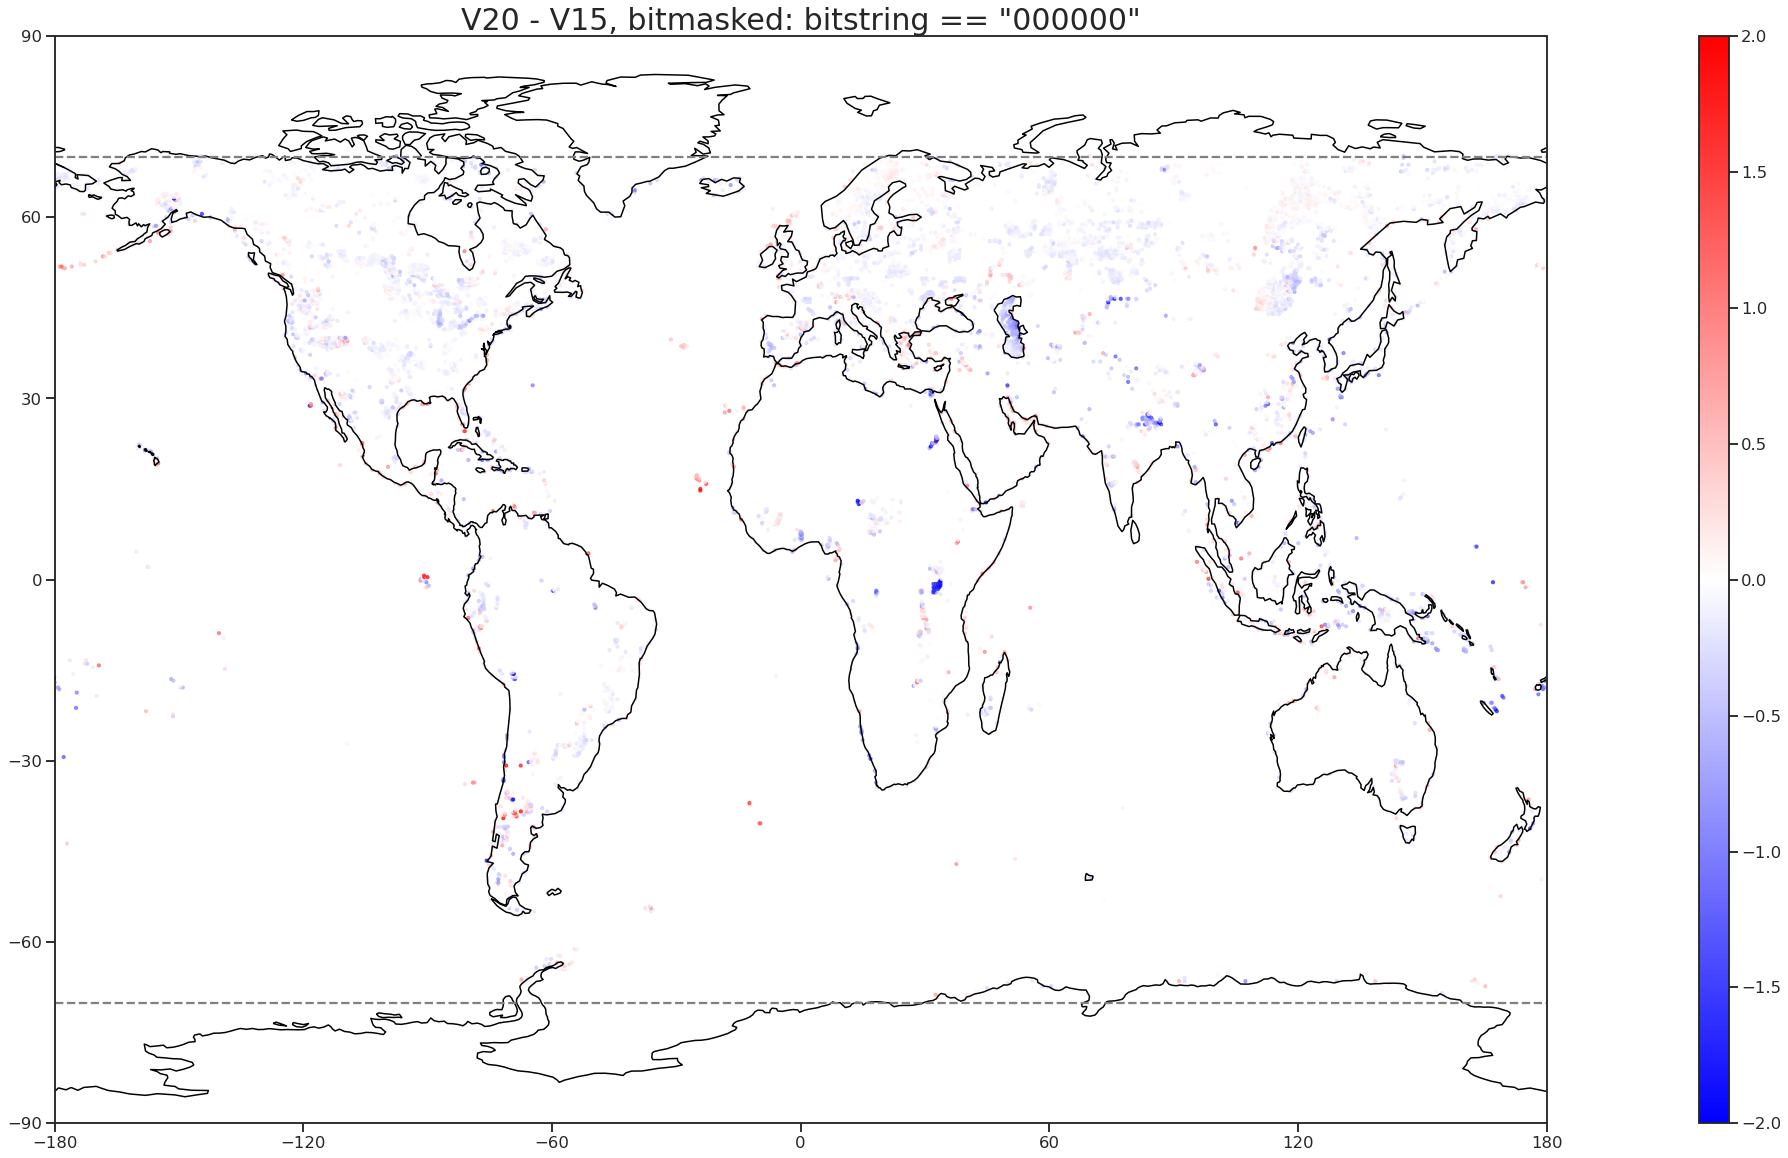

Number of samples: 9119
Distribution Mean/Median: -0.06785756 -0.055238247


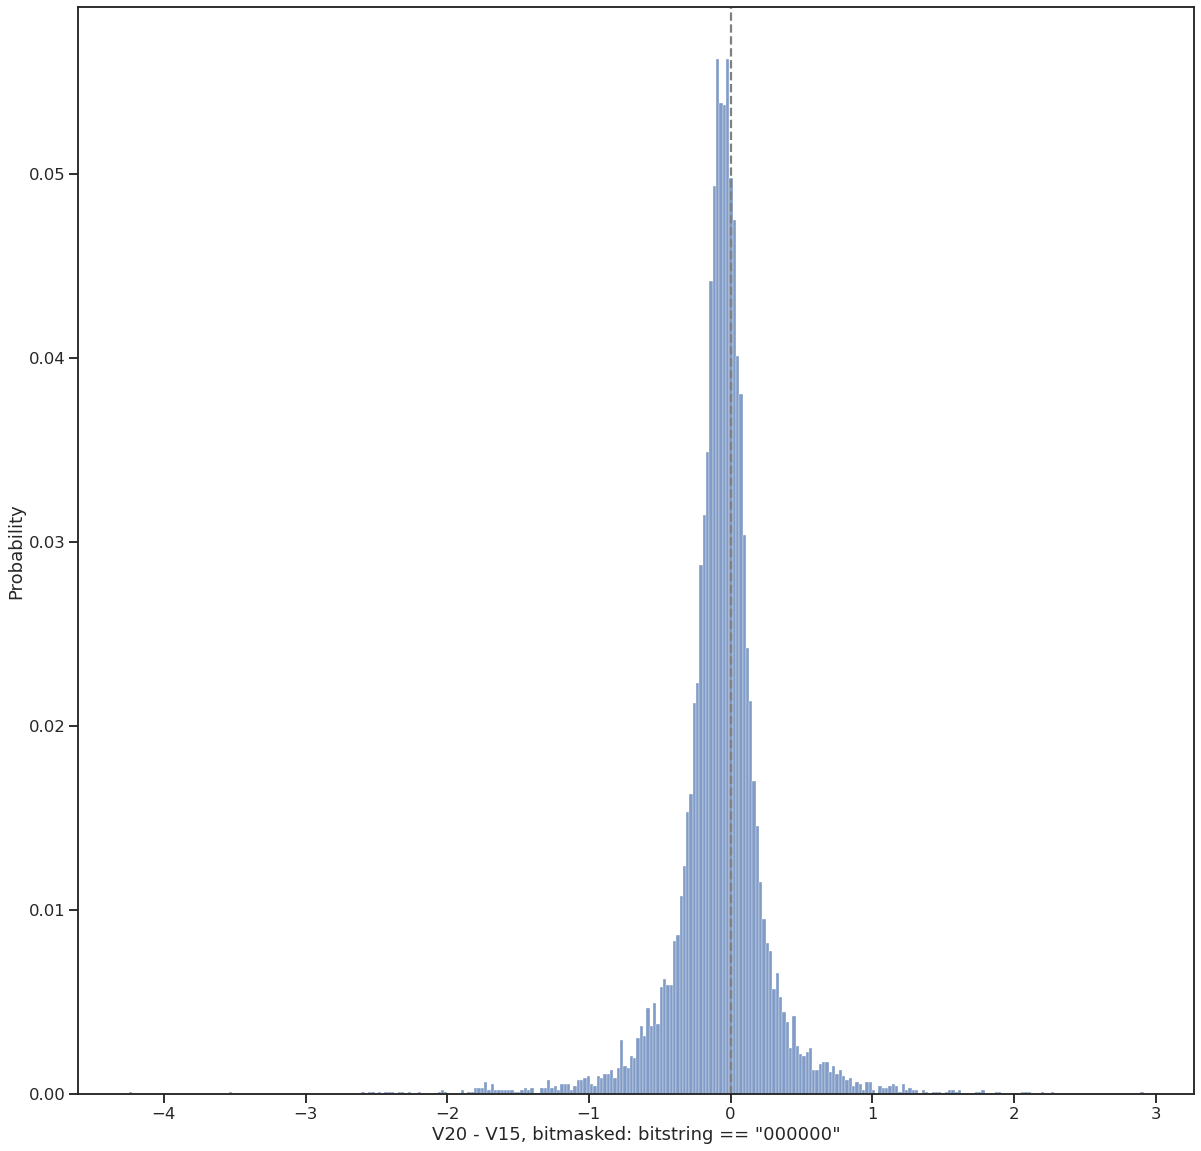

In [100]:
queries = ['bitstring == "000000"']

for p in queries:
    #Create a mask
    mask = change_in_fields.query(p)


    #Plot the mask
    plot_map(mask,'change_in_cl',vmin=-0.1,vmax=0.1,cmap=plt.cm.viridis,logscale=False,title=f'Bitstring mask: {p}',limits=None,markersize=10,savefig=None) #What does this mask look like?


    #Apply the mask to the global error_delta_field from earlier
    V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

    if len(V20_V15_masked) == 0:
        print ('No values with this group')
        continue

    # Plot it, along with a distribution of the errors
    plot_map(V20_V15_masked,
             'delta',
             vmin=-2,vmax=+2,
             cmap= plt.cm.bwr,
             logscale=False,
             title=f'V20 - V15, bitmasked: {p}',
             limits=None,
             markersize=10,
             savefig=None)


    plot_distribution(V20_V15_masked,'delta',f'V20 - V15, bitmasked: {p}')

In [101]:
mask = change_in_fields.copy()

#Apply the mask to the global error_delta_field from earlier
V20_V15_masked = pd.merge(V20_V15,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.

In [40]:
V20_V15_masked.groupby(['bitstring']).count()

latitude_ERA  longitude_ERA  MODIS_LST  V15_prediction  \
bitstring                                                           
000000             9119           9119       9119            9119   
000001               43             43         43              43   
000010               22             22         22              22   
000011                5              5          5               5   
000100           135005         135005     135005          135005   
000101              834            834        834             834   
000110              247            247        247             247   
000111              114            114        114             114   
001000                8              8          8               8   
001010                1              1          1               1   
001100               40             40         40              40   
001110               22             22         22              22   
010000                1              1          1               1   
010100               13             13         13              13   
011000                3              3          3               3   
011100               18             18         18              18   
011110                1              1          1               1   
100000              234            234        234             234   
100010              104            104        104             104   
100011                3              3          3               3   
100100             2392           2392       2392            2392   
100101               19             19         19              19   
100110             1512           1512       1512            1512   
100111               17             17         17              17   
101010                2              2          2               2   
101100                8              8          8               8   
101110               21             21         21              21   
111110                2              2          2               2   

           V20_prediction  V15_error  V20_error   delta  values    step  ...  \
bitstring                                                                ...   
000000               9119       9119       9119    9119    9119    9119  ...   
000001                 43         43         43      43      43      43  ...   
000010                 22         22         22      22      22      22  ...   
000011                  5          5          5       5       5       5  ...   
000100             135005     135005     135005  135005  135005  135005  ...   
000101                834        834        834     834     834     834  ...   
000110                247        247        247     247     247     247  ...   
000111                114        114        114     114     114     114  ...   
001000                  8          8          8       8       8       8  ...   
001010                  1          1          1       1       1       1  ...   
001100                 40         40         40      40      40      40  ...   
001110                 22         22         22      22      22      22  ...   
010000                  1          1          1       1       1       1  ...   
010100                 13         13         13      13      13      13  ...   
011000                  3          3          3       3       3       3  ...   
011100                 18         18         18      18      18      18  ...   
011110                  1          1          1       1       1       1  ...   
100000                234        234        234     234     234     234  ...   
100010                104        104        104     104     104     104  ...   
100011                  3          3          3       3       3       3  ...   
100100               2392       2392       2392    2392    2392    2392  ...   
100101                 19         19         19      19      19      19  ...   
100110              